In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from datetime import datetime

# ---------- Step 1: Load the dataset ----------
csv_file = 'Insitu_nan_row_removed.csv'
df = pd.read_csv(csv_file)
df.replace("Nan", np.nan, inplace=True)

# Convert all data columns (after Lat and Lon) to float
df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

# Extract date columns and convert them to datetime
date_cols = df.columns[2:]
date_times = pd.to_datetime(date_cols, format='%Y-%m')

# ---------- Step 2: Process and Plot Each Row ----------
for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    values = row[2:].values.astype(float)

    # Get valid indices (not NaN)
    valid_mask = ~np.isnan(values)
    if np.sum(valid_mask) < 4:
        print(f"Skipping row {idx} at (Lat, Lon) = ({lat}, {lon}) due to insufficient data.")
        continue

    valid_dates = date_times[valid_mask]
    valid_values = values[valid_mask]

    # Convert datetime to days for interpolation
    x = (valid_dates - valid_dates[0]).days
    x_all = (date_times - valid_dates[0]).days

    # Apply cubic spline interpolation
    cs = CubicSpline(x, valid_values)
    interpolated = cs(x_all)

    # Only consider plotting between the first and last valid points
    first_valid_idx = valid_mask.argmax()
    last_valid_idx = len(valid_mask) - np.argmax(valid_mask[::-1])  # index of last True

    plot_dates = date_times[first_valid_idx:last_valid_idx]
    plot_values = interpolated[first_valid_idx:last_valid_idx]

    # Set y-axis limits dynamically per plot
    local_min = np.min(plot_values)
    local_max = np.max(plot_values)
    padding = (local_max - local_min) * 0.1  # 10% padding
    ymin = local_min - padding
    ymax = local_max + padding

    # ---------- Step 3: Plot ----------
    plt.figure(figsize=(14, 5))
    plt.plot(plot_dates, plot_values, label='Cubic Spline', color='blue')
    plt.scatter(valid_dates, valid_values, label='Original Data', color='red')
    plt.title(f'Cubic Spline Interpolation for (Lat: {lat}, Lon: {lon})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.ylim(ymin, ymax)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)

    plt.show()
    # Optional: Save plot
    # plt.savefig(f'spline_plot_{lat}_{lon}.png')


In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# ---------- Step 1: Load the dataset ----------
csv_file = 'Insitu_nan_row_removed.csv'
df = pd.read_csv(csv_file)
df.replace("Nan", np.nan, inplace=True)

# Convert all data columns (after Lat and Lon) to float
df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

# Extract date columns and convert them to datetime
date_cols = df.columns[2:]
date_times = pd.to_datetime(date_cols, format='%Y-%m')

# ---------- Step 2: Process and Compute Metrics ----------
results = []

for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    values = row[2:].values.astype(float)

    valid_mask = ~np.isnan(values)
    if np.sum(valid_mask) < 6:
        continue  # Skip rows with too few data points

    valid_dates = date_times[valid_mask]
    valid_values = values[valid_mask]

    total_points = len(valid_values)
    split_idx = int(total_points * 0.8)

    train_dates = valid_dates[:split_idx]
    train_values = valid_values[:split_idx]
    test_dates = valid_dates[split_idx:]
    test_values = valid_values[split_idx:]

    if len(test_values) < 2:
        continue  # Need at least 2 points to evaluate properly

    # Convert to relative days
    x_train = (train_dates - train_dates[0]).days
    x_test = (test_dates - train_dates[0]).days

    try:
        cs = CubicSpline(x_train, train_values)
        y_pred = cs(x_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(test_values, y_pred)
        rmse = mean_squared_error(test_values, y_pred, squared=False)
        r2 = r2_score(test_values, y_pred)

        results.append({
            'Index': idx,
            'Lat': lat,
            'Lon': lon,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

    except Exception:
        continue  # Skip problematic rows

# ---------- Step 3: Output Metrics ----------
results_df = pd.DataFrame(results)
pd.set_option("display.precision", 4)
print(results_df)

# Optional: Save to CSV
# results_df.to_csv("cubic_spline_results.csv", index=False)


     Index    Lat    Lon        MAE       RMSE          R2
0        0  23.00  74.25  1712.2866  2584.8018 -1.6228e+06
1        1  23.00  74.50  1038.0240  1363.7414 -6.3697e+05
2        2  23.25  73.75  1685.1827  2342.2481 -1.0203e+06
3        3  23.25  74.00  1703.6343  2579.8682 -1.8602e+06
4        4  23.25  74.25    85.2740   118.7167 -3.3209e+04
..     ...    ...    ...        ...        ...         ...
918    918  32.00  75.25   932.8197  1354.4477 -1.2120e+06
919    919  32.00  75.50  2541.0897  3867.8991 -5.7260e+07
920    920  32.25  75.25    92.2323   125.4862 -2.2815e+04
921    921  32.25  75.50  2878.6908  4379.4206 -5.3625e+07
922    922  32.25  75.75    42.0896    53.3926 -1.4992e+04

[923 rows x 6 columns]



Zone-wise Performance Statistics:
                  MAE              RMSE                   R2            
                 mean      std     mean      std        mean         std
Zone                                                                    
Central-East  1415.28  5373.91  2018.04  6446.45 -9.2493e+06  5.9231e+07
Central-West  1558.92  3154.22  2343.15  4783.83 -3.2143e+30  4.8853e+31
North-East    1098.53  1190.29  1685.51  1846.55 -5.1846e+06  1.1060e+07
North-West     625.72   807.95   977.12  1319.82 -2.6851e+06  4.7038e+06
South-East    1876.18  1944.45  2789.06  3036.65 -4.3413e+06  6.9658e+06
South-West    1898.70  2090.55  2811.32  3151.36 -3.8920e+06  1.9723e+07


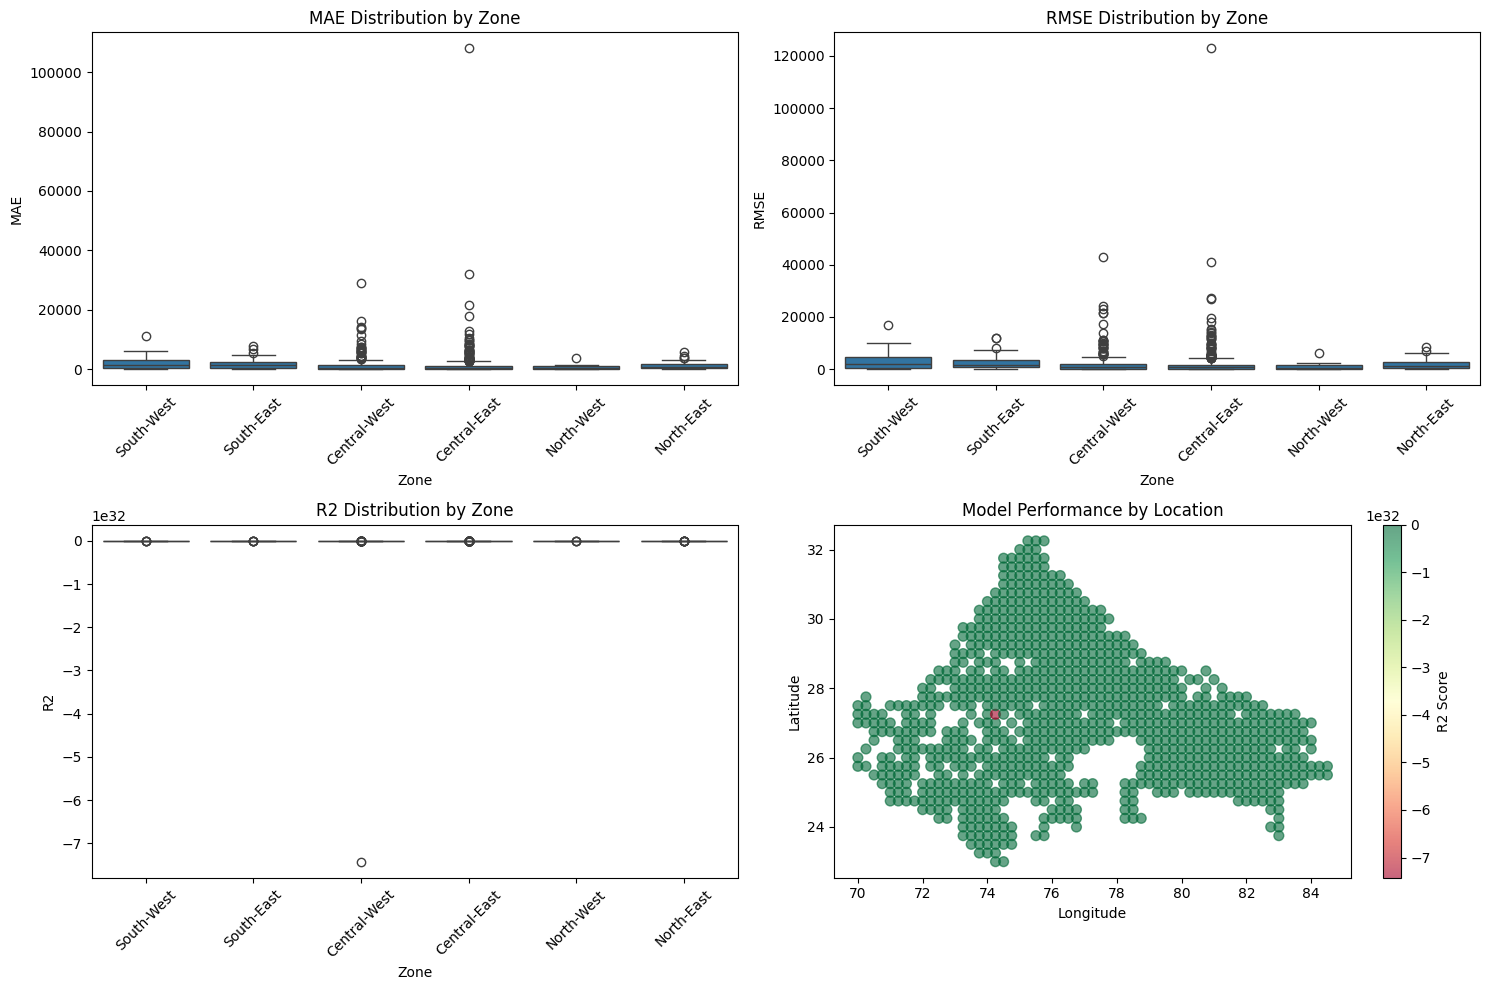


Best Performing Zones (based on R2):
Zone
North-West   -2.6851e+06
South-West   -3.8920e+06
South-East   -4.3413e+06
Name: R2, dtype: float64

Worst Performing Zones (based on R2):
Zone
Central-West   -3.2143e+30
Central-East   -9.2493e+06
North-East     -5.1846e+06
Name: R2, dtype: float64

Number of locations in each zone:
Zone
Central-East    507
Central-West    231
North-East       67
South-West       57
South-East       36
North-West       25
Name: count, dtype: int64


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from previous analysis
results_df = pd.DataFrame(results)

# Define zones based on latitude and longitude ranges
def assign_zone(lat, lon):
    if lat < 25:
        if lon < 75:
            return 'South-West'
        else:
            return 'South-East'
    elif lat < 30:
        if lon < 75:
            return 'Central-West'
        else:
            return 'Central-East'
    else:
        if lon < 75:
            return 'North-West'
        else:
            return 'North-East'

# Add zone column to results
results_df['Zone'] = results_df.apply(lambda x: assign_zone(x['Lat'], x['Lon']), axis=1)

# Calculate zone-wise statistics
zone_stats = results_df.groupby('Zone').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).round(2)

print("\nZone-wise Performance Statistics:")
print(zone_stats)

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Zone-wise MAE Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(x='Zone', y='MAE', data=results_df)
plt.title('MAE Distribution by Zone')
plt.xticks(rotation=45)

# 2. Zone-wise RMSE Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(x='Zone', y='RMSE', data=results_df)
plt.title('RMSE Distribution by Zone')
plt.xticks(rotation=45)

# 3. Zone-wise R2 Box Plot
plt.subplot(2, 2, 3)
sns.boxplot(x='Zone', y='R2', data=results_df)
plt.title('R2 Distribution by Zone')
plt.xticks(rotation=45)

# 4. Scatter plot of locations colored by R2 score
plt.subplot(2, 2, 4)
scatter = plt.scatter(results_df['Lon'], results_df['Lat'], 
                     c=results_df['R2'], cmap='RdYlGn',
                     s=50, alpha=0.6)
plt.colorbar(scatter, label='R2 Score')
plt.title('Model Performance by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Print summary of best and worst performing zones
print("\nBest Performing Zones (based on R2):")
best_zones = results_df.groupby('Zone')['R2'].mean().sort_values(ascending=False)
print(best_zones.head(3))

print("\nWorst Performing Zones (based on R2):")
worst_zones = results_df.groupby('Zone')['R2'].mean().sort_values()
print(worst_zones.head(3))

# Additional analysis: Count of locations in each zone
zone_counts = results_df['Zone'].value_counts()
print("\nNumber of locations in each zone:")
print(zone_counts)


📊 Zone-wise Performance Statistics:
             MAE                RMSE                     R2            
            mean       std      mean        std        mean         std
Zone                                                                   
Zone-1   861.220  1084.483  1294.742   1708.863 -2.5100e+06  1.0425e+07
Zone-2  1109.473  1893.325  1696.738   3007.004 -5.3035e+30  6.2752e+31
Zone-3  2101.319  3667.237  3105.210   5498.352 -5.0177e+06  2.0221e+07
Zone-4  1830.584  8688.041  2460.064  10152.218 -1.3296e+07  6.7690e+07
Zone-5  1124.379  1846.305  1713.431   2789.176 -2.2281e+07  1.2475e+08
Zone-6  2168.509  2853.432  3213.821   4282.311 -1.5364e+07  9.1181e+07


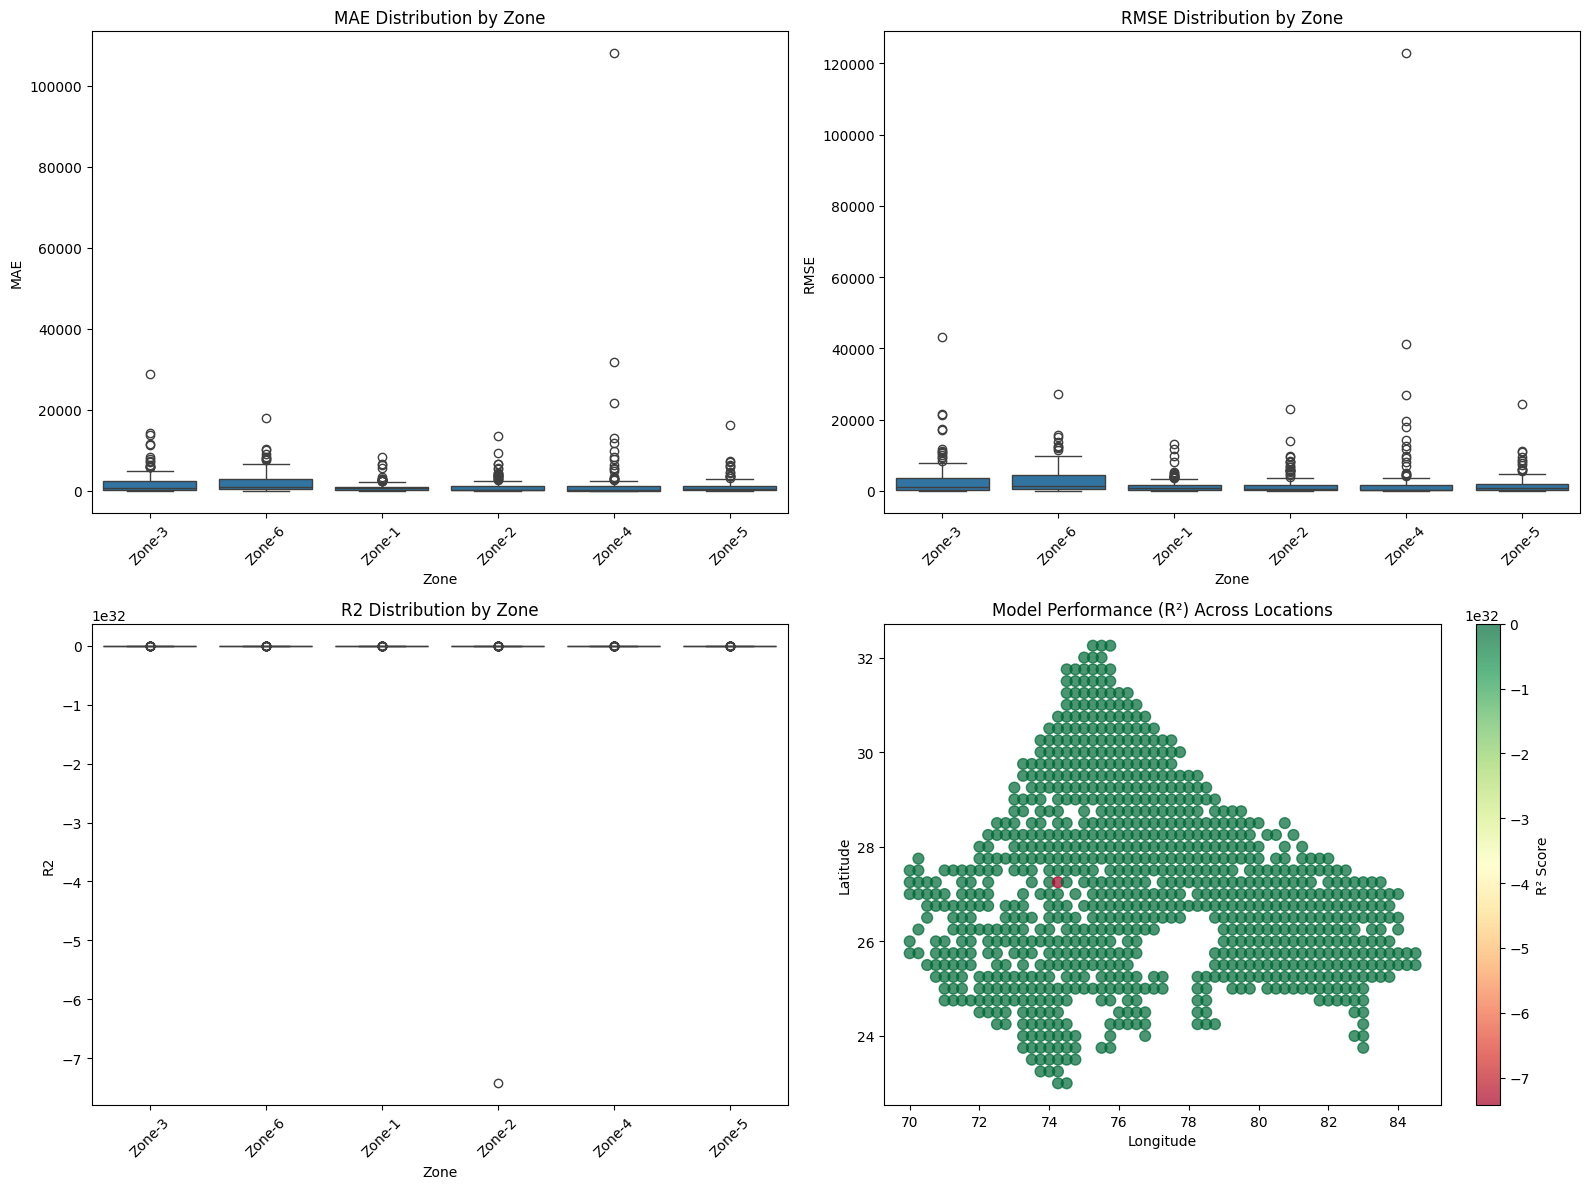


🏆 Top Performing Zones (by mean R²):
Zone
Zone-1   -2.5100e+06
Zone-3   -5.0177e+06
Zone-4   -1.3296e+07
Name: R2, dtype: float64

⚠️ Lowest Performing Zones (by mean R²):
Zone
Zone-2   -5.3035e+30
Zone-5   -2.2281e+07
Zone-6   -1.5364e+07
Name: R2, dtype: float64

📍 Data Points per Zone:
Zone
Zone-1    212
Zone-4    178
Zone-5    158
Zone-2    140
Zone-3    124
Zone-6    111
Name: count, dtype: int64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# -------------------- Load Results --------------------
results_df = pd.DataFrame(results)  # from your earlier CubicSpline model

# -------------------- Dynamic Zoning via KMeans --------------------
# Choose number of zones (clusters)
n_zones = 6  # Change this to 4, 6, 8... depending on how granular you want

# Standardize Lat & Lon for clustering
scaler = StandardScaler()
coords = scaler.fit_transform(results_df[['Lat', 'Lon']])

# KMeans Clustering
kmeans = KMeans(n_clusters=n_zones, random_state=42)
zone_labels = kmeans.fit_predict(coords)

# Add cluster labels to DataFrame as 'Zone'
results_df['Zone'] = ['Zone-' + str(i+1) for i in zone_labels]

# -------------------- Zone-wise Statistics --------------------
zone_stats = results_df.groupby('Zone').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).round(3)

print("\n📊 Zone-wise Performance Statistics:")
print(zone_stats)

# -------------------- Visualizations --------------------
plt.figure(figsize=(16, 12))

# 1. MAE Box Plot
plt.subplot(2, 2, 1)
sns.boxplot(x='Zone', y='MAE', data=results_df)
plt.title('MAE Distribution by Zone')
plt.xticks(rotation=45)

# 2. RMSE Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(x='Zone', y='RMSE', data=results_df)
plt.title('RMSE Distribution by Zone')
plt.xticks(rotation=45)

# 3. R2 Box Plot
plt.subplot(2, 2, 3)
sns.boxplot(x='Zone', y='R2', data=results_df)
plt.title('R2 Distribution by Zone')
plt.xticks(rotation=45)

# 4. R2 vs Location (Map View)
plt.subplot(2, 2, 4)
scatter = plt.scatter(results_df['Lon'], results_df['Lat'], 
                      c=results_df['R2'], cmap='RdYlGn', s=60, alpha=0.7)
plt.colorbar(scatter, label='R² Score')
plt.title('Model Performance (R²) Across Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# -------------------- Summary --------------------
print("\n🏆 Top Performing Zones (by mean R²):")
print(results_df.groupby('Zone')['R2'].mean().sort_values(ascending=False).head(3))

print("\n⚠️ Lowest Performing Zones (by mean R²):")
print(results_df.groupby('Zone')['R2'].mean().sort_values().head(3))

print("\n📍 Data Points per Zone:")
print(results_df['Zone'].value_counts())
